# Descripción de la solución

## Mapa del mundo
El agente que proponemos es un agente reactivo con memoria, que tiene en cuenta la historia sensorial previa para crear una representación icónica del mundo que le rodea. En particular, el agente almacena un mapa que toma como punto de referencia la posición inicial del agente en el mapa real. Sobre ese mapa se almacena si se han visitado o no las casillas y si en ellas había una pared o estaban libres. Teniendo en cuenta esto, el agente evita moverse hacia las casillas ocupadas.

## Valor de una casilla
Para decidir hacia qué casilla se dirigirá a cada paso, el agente calcula un valor para cada una de las casillas. Este valor tiene en cuenta:

* La cantidad de **trufa** esperada en la casilla.
* Un factor que penaliza los **giros**.
* Un factor que premia el **explorar** nuevas casillas.

Con todo esto, el agente decide dirigirse a la casilla de más valor. El cálculo del valor de una casilla puede verse como un uso simplificado del concepto de *mapa de potencial*.

## Decisión de recoger
Para decidir si en una determinada casilla el robot debe recoger trufas o seguir moviéndose, se usa el valor esperado de trufas en esa casilla. Este es un valor que se calcula a partir del crecimiento probabilístico esperado a cada paso, y, si supera un cierto umbral marcado por el valor `SUFICIENTE_TRUFA`, se decide recoger.

# Resultados obtenidos

Para medir la bondad de una solución, usamos durante el proceso la media geométrica de las mejoras respecto a la solución aleatoria inicial. Nótese que la media geométrica de las mejoras es comparable independientemente de la referencia.

In [17]:
%matplotlib inline
import os
import subprocess
from scipy.stats.mstats import gmean
from __future__ import division

In [25]:
# Test the agent against all the different maps in 'map'.
allmaps = os.listdir('map')

def testmaps(maps = allmaps):
    test = []

    for filename in maps:
        result = subprocess.check_output('./agent '+ './map/' + filename, shell=True)
        test.append(float(result))

    return test

In [19]:
# Builds the executable
def make(strategy):
    return subprocess.check_output(
     "g++ main.cpp environment.cpp agent.cpp evaluator.cpp random_num_gen.cpp -o agent -fpermissive " + strategy,
     shell=True
    )

In [38]:
# Measures the goodness of a solution
standard_results = [349.2, 634.5, 408.3, 530.6, 660.1, 389.7, 477.7, 498.2]
standard_fast_results = [349.2, 408.3, 389.7, 498.2]
standard_slow_results = [634.5, 530.6, 660.1, 477.7]

def goodness(results, st=standard_results):
    proportions = [a/b for a,b in zip(results,st)]
    return gmean(proportions)

In [44]:
make("")
print testmaps()
print goodness(testmaps())

[2610.5, 1330.1, 2790.3, 1453.3, 1365.2, 2981.0, 1219.8, 3042.3]
4.04984999091


Concluyendo así que nuestra solución es en media `4.0498` veces mejor que la aleatoria.

# Otras estrategias

El resto de estrategias que se implementaron pueden observarse usando complilación condicional sobre el código dado.

Para cada solución se muestra su bondad respecto a la solución aleatoria y la lista ordenada alfabéticamente de valores sobre el mapa inicial.

## Estrategia: Aleatoria

Escoje aleatoriamente una acción entre las cuatro. Sólo la usamos como referencia.

In [36]:
make("-DRANDOM")
print testmaps()
print goodness(testmaps())

[349.2, 634.5, 408.3, 530.6, 660.1, 389.7, 477.7, 498.2]
1.0


## Estrategia: Casi aleatoriamente

Aleatoriamente, pero omitiendo la acción de observar. Mejora sólo sutilmente la aleatoria.

In [14]:
make("-DRANDOMLY")
print testmaps()
print goodness(testmaps())

[499.5, 726.5, 451.9, 634.4, 807.7, 539.8, 552.8, 689.9]
1.24805226388


## Estrategia: Paredes

En esta primera estrategia, se combinaba la aleatoriedad con una representación icónica del mundo. Evitaba caminar contra una pared y evita en lo posible girar hacia donde luego encontrará una pared. La solución final fue un refinamiento de esta solución con el cálculo de valores para cada casilla.

In [23]:
make("-DWALLS")
print testmaps()
print goodness(testmaps())

[895.3, 890.1, 628.3, 846.1, 877.6, 893.7, 641.6, 833.4]
1.66986494108


## Refinamientos de la solución
### Estudio del factor `SUFICIENTE_TRUFA`

La constante `SUFICIENTE_TRUFA` determina cuándo el agente cree que ha crecido suficiente trufa para ser recolectada. Lo que hará será empezar a recolectar una vez haya suficiente. La variación de esta constante variará la frecuencia con la 
que se recolecta.

Un factor razonable es `10.000`, porque se llega a él en el tiempo esperado de crecimiento de una trufa con crecimiento del `p = 1.5`. Pero probar valores por encima y por debajo puede ser interesante. Se presenta una gráfica con la variación de la bondad según la variación de esta constante.

In [43]:
make("-DMAP -DSUFICIENTE_TRUFA=" + str(4500))
print goodness(testmaps())

4.04984999091


In [18]:
from pylab import *
x = linspace(0,20000,41)
y = []
for xi in x:
    make("-DMAP -DSUFICIENTE_TRUFA=" + str(xi))
    y.append(goodness(testmaps())) 

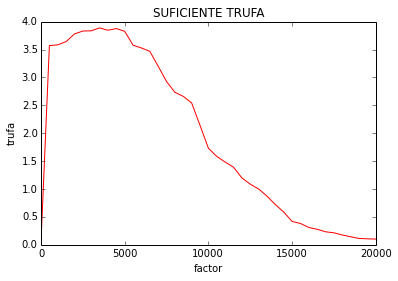

In [19]:
figure()
plot(x, y, 'r')
xlabel('factor')
ylabel('trufa')
title('SUFICIENTE TRUFA')
show()

Obtenemos que el valor general más razonable para `SUFICIENTE_TRUFA` está alrededor de los `4500`.

### El factor en mapas de crecimiento rápido y lento

Podemos particularizar el estudio a cada uno de los dos posibles casos.

In [45]:
rapidmaps = ['mapa3_rap.map',
             'agent_rap.map',
             'mapa2_rap.map',
             'mapa1_rap.map']

slowmaps = ['mapa2.map',
            'mapa3.map',
            'mapa1.map',
            'agent.map']

print testmaps(rapidmaps)
print goodness(testmaps(rapidmaps),standard_fast_results)
print testmaps(slowmaps)
print goodness(testmaps(rapidmaps),standard_slow_results)

print testmaps()
print goodness(testmaps())

[2610.5, 2790.3, 2981.0, 3042.3]
6.98936493018
[1330.1, 1453.3, 1365.2, 1219.8]
4.99451924612
[2610.5, 1330.1, 2790.3, 1453.3, 1365.2, 2981.0, 1219.8, 3042.3]
4.04984999091


In [46]:
from pylab import *
x = linspace(0,10000,41)
y = []
for xi in x:
    make("-DMAP -DSUFICIENTE_TRUFA=" + str(xi))
    y.append(goodness(testmaps(rapidmaps), standard_fast_results))

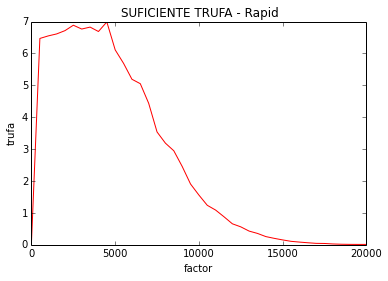

In [48]:
figure()
plot(x, y, 'r')
xlabel('factor')
ylabel('trufa')
title('SUFICIENTE TRUFA - Rapid')
show()

In [49]:
from pylab import *
x = linspace(0,10000,41)
y = []
for xi in x:
    make("-DMAP -DSUFICIENTE_TRUFA=" + str(xi))
    y.append(goodness(testmaps(slowmaps), standard_slow_results))

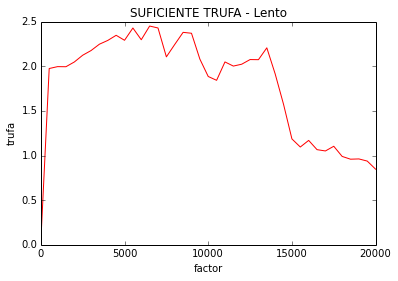

In [50]:
figure()
plot(x, y, 'r')
xlabel('factor')
ylabel('trufa')
title('SUFICIENTE TRUFA - Lento')
show()

### Estudio del factor de giro

El factor de giro mide la relación entre la bondad de una casilla y el coste en tiempo de girar para alcanzarla. Cuanto mayor sea, menos valor se le otorga a las casillas a las que se deba girar para alcanzarlas. El factor original era de `1.5`. Probaremos valores razonables entre `1` y `2`.

Encontramos que no podemos establecer ninguna correlación razonable. Tomaremos un factor de giro de `1.1`.

In [29]:
from pylab import *
x = linspace(1,1.5,11)
y = []
for xi in x:
    make("-DMAP -DFACTOR_GIRO=" + str(xi))
    y.append(goodness(testmaps())) 

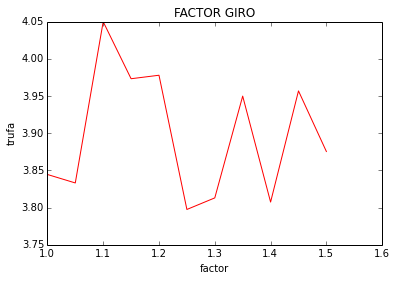

In [30]:
figure()
plot(x, y, 'r')
xlabel('factor')
ylabel('trufa')
title('FACTOR GIRO')
show()